In [1]:
from Chemometrics.data_io import read_cdf
from Chemometrics.import_common import *
import glob
import re
import xarray as xr
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
import gc

In [2]:
files = glob.glob('./洋河2018新数据-换柱子/**/**/*.CDF')

343

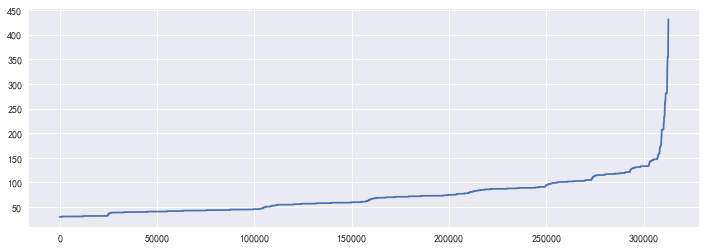

In [3]:
plt.figure(figsize=(12,4))
with read_cdf(files[0]) as f:
    plt.plot(np.sort(f.mass_values.values))
gc.collect()

In [4]:
# 提取目标信息

In [5]:
fh = np.vectorize(lambda x: re.search('(?<=A\\\).+(?=\\\sample)', x)[0])
target = fh(files)
sample_number = np.vectorize(lambda x: re.search('(?<=柱子\\\\).*(?=\s)', x)[0] + re.search('sample.+(?=\.CDF)', x)[0])
SN = sample_number(files)

In [6]:
_y = pd.DataFrame({'target': target, 'SN': SN})
y = _y.target
y.head()

0    优绵
1    优绵
2    优绵
3    优绵
4    优绵
Name: target, dtype: object

In [7]:
# 处理GCMS质谱数据

In [8]:
def agg_mz(gcms, shreshold=.1):
    mz = gcms['mass_values']
    _a = pd.DataFrame({'it': gcms['intensity_values'].values,
             'mz': mz})
    _as = _a.sort_values(by='mz')
    gby = (_as.mz.diff() >  shreshold).cumsum()
    mzit = _as.groupby(by=gby).agg({'it': 'sum', 
                                    'mz': 'mean'})
    return mzit.set_index('mz')

def reduce_mz(file, shreshold=.1):
    gcms = read_cdf(file)
    mzit = agg_mz(gcms, shreshold=shreshold)
    return mzit

In [9]:
#pd.DataFrame([gcms['mass_values'], gcms['intensity_values']])

In [10]:
_amz = pd.concat([reduce_mz(file) for file in files], axis=1)
_amz.columns = SN

In [11]:
_amz.fillna(0, inplace=True)

In [12]:
_gby = (pd.Series(_amz.index).diff()>.1).cumsum()

In [13]:
grp = _amz.reset_index().groupby(by=_gby)
_idx = grp['mz'].mean()
mzs = grp.sum()
mzs.index = _idx
mzs.drop('mz', axis=1, inplace=True)

In [14]:
SN_test = ['01sample-' + str(i) for i in range(13,20)]

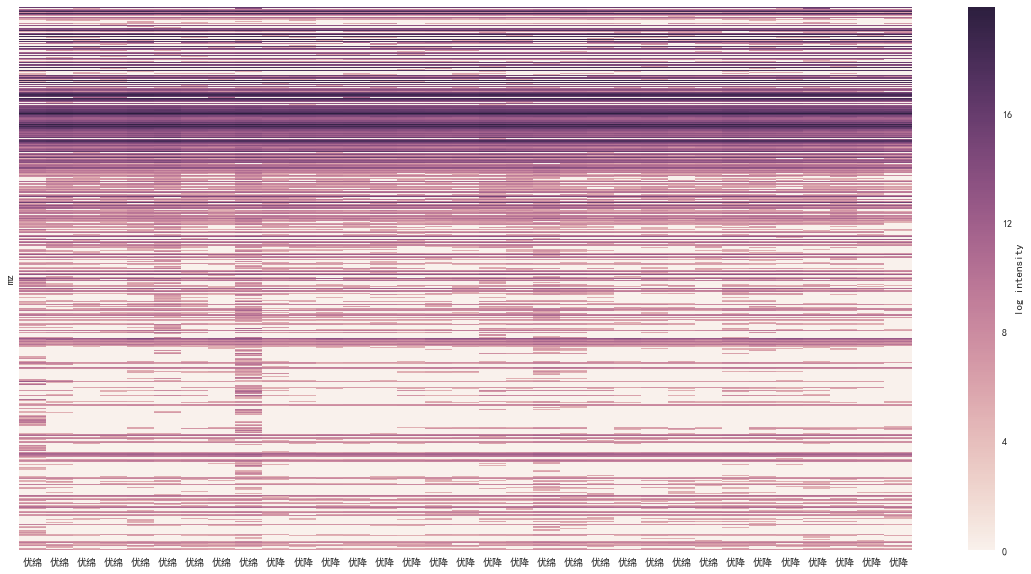

In [35]:
plt.figure(figsize=(20,10))
sns.heatmap(np.log(mzs+1), yticklabels=False, xticklabels=y_.values, cbar_kws={'label': 'log intensity'})
plt.savefig('洋河GC-MS换柱子.png', dpi=300)

In [15]:
test_mask = mzs.columns.isin(SN_test)
X_test = mzs.loc[:, test_mask].T
X_train = mzs.loc[:, ~test_mask].T
test_mask = _y.SN.isin(SN_test)
y_ = _y.set_index('SN').target
y_test = y_.loc[test_mask.values]
y_train = y_.loc[~test_mask.values]

In [16]:
lr = LogisticRegression()

In [17]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
#预处理
pipe = Pipeline(steps=[('normalizer', Normalizer()),\
                       ('standardscaler', StandardScaler()),\
                       ('clf', lr)])

In [18]:
from sklearn.model_selection import GridSearchCV
params = dict(clf__C=np.logspace(-5, 0, 20))
grid0 = GridSearchCV(pipe, param_grid=params, cv=5)

In [19]:
with timer('LR+preprocessing'):
    grid0.fit(X_train, y_train)

LR+preprocessing done in 0.58s


In [20]:
_cv = pd.DataFrame(dict(grid.cv_results_))
plt.plot(_cv.param_clf__C, _cv.mean_test_score, label='test')
plt.plot(_cv.param_clf__C, _cv.mean_train_score, label='train')
plt.legend()
plt.title('洋河GCMS-白酒等级训练-交叉验证调整超参数')

NameError: name 'grid' is not defined

In [ ]:
#模型效果
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report
ypred_cv = cross_val_predict(grid.best_estimator_, X_train, y_train)
scores_cv = cross_val_score(grid.best_estimator_, X_train, y_train)
cm_cvpred = confusion_matrix(y_train, ypred_cv)
plot_ConfusionMatrix(cm_cvpred, grid.classes_)
plt.title('{sample-mz-concat-normalizer-standardscaler: LR}模型训练集预测效果')
print(classification_report(y_train, ypred_cv, labels=grid.classes_))

In [ ]:
#test prediction
ypred_test = grid.predict(X_test)
print(classification_report(y_test, ypred_test))
cm_test = confusion_matrix(y_test, ypred_test)
plot_ConfusionMatrix(cm_test, grid.classes_)
plt.title('{pipe: LR}模型测试集预测效果')

In [ ]:
psave({'X_train': X_train,
      'X_test': X_test,
      'y_train': y_train,
      'y_test': y_test},
     '洋河2018换柱子后Xy.p')

In [ ]:
gc.collect()

In [ ]:
# log transformation
from sklearn.preprocessing import FunctionTransformer
log1p = FunctionTransformer(np.log1p)
pipe = Pipeline(steps=[ ('log1p', log1p),
                        ('normalizer', Normalizer()),
                       ('standardscaler', StandardScaler()),
                       ('clf', lr)])
params = dict(clf__C=np.logspace(-5, 0, 20))
grid = GridSearchCV(pipe, param_grid=params, cv=5)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
_cv = pd.DataFrame(dict(grid.cv_results_))

In [ ]:
plt.plot(_cv.param_clf__C, _cv.mean_test_score, label='test')
plt.plot(_cv.param_clf__C, _cv.mean_train_score, label='train')
plt.legend()

假设检验： 加入log1p转换后，效果有没有变化

In [ ]:
scores_h0 = cross_val_score(grid0.best_estimator_, X_train, y_train)
scores_h1 = cross_val_score(grid.best_estimator_, X_train, y_train)

In [ ]:
grid, grid0

In [ ]:
stats.ttest_ind(scores_h0,scores_h1)

In [ ]:
stats.ttest_ind(scores_h0,scores_h1)

pvalue =1, 说明两者均值没有区别